In [1]:
########################################################################################################################
#                                                          IMPORT                                                      #
########################################################################################################################
import torch
import sys
import os
import json
import numpy as np
sys.path.append('..')

from singleVis.SingleVisualizationModel import VisModel

from singleVis.data import NormalDataProvider

from singleVis.projector import DVIProjector
from singleVis.eval.evaluator import Evaluator

VIS_METHOD = "DVI" # DeepVisualInsight

########################################################################################################################
#                                                     LOAD PARAMETERS                                                  #
########################################################################################################################
CONTENT_PATH = "/home/yifan/0ExpMinist/Default/01"

sys.path.append(CONTENT_PATH)
with open(os.path.join(CONTENT_PATH, "config.json"), "r") as f:
    config = json.load(f)
config = config[VIS_METHOD]

# record output information
# now = time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime(time.time())) 
# sys.stdout = open(os.path.join(CONTENT_PATH, now+".txt"), "w")

SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
PREPROCESS = config["VISUALIZATION"]["PREPROCESS"]
GPU_ID = config["GPU"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
LAMBDA1 = VISUALIZATION_PARAMETER["LAMBDA1"]
LAMBDA2 = VISUALIZATION_PARAMETER["LAMBDA2"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = VISUALIZATION_PARAMETER["VIS_MODEL_NAME"]
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]



# VIS_MODEL_NAME = 'dvi_grid'

# Define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))

# Define data_provider
data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, epoch_name='Epoch',classes=CLASSES,verbose=1)


# Define visualization models
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

# Define Projector
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device=DEVICE)    

########################################################################################################################
#                                                      VISUALIZATION                                                   #
########################################################################################################################

from singleVis.visualizer import visualizer

vis = visualizer(data_provider, projector, 200, "tab10")
save_dir = os.path.join(data_provider.content_path, "imgptDVI")
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-26 15:28:01.079878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 15:28:01.604960: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-26 15:28:01.605001: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinf

Finish initialization...


In [73]:
epoch = 20

def if_border(data):
    mesh_preds = data_provider.get_pred(epoch, data)
    mesh_preds = mesh_preds + 1e-8

    sort_preds = np.sort(mesh_preds, axis=1)
    diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
    border = np.zeros(len(diff), dtype=np.uint8) + 0.05
    border[diff < 0.15] = 1
        
    return border
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi', device=DEVICE)  
training_emd = projector.batch_project(epoch, data_provider.train_representation(epoch))

training_new_data = projector.batch_inverse(epoch,training_emd )
pred =  data_provider.get_pred(epoch, data_provider.train_representation(epoch)).argmax(axis=1)
new_pred = data_provider.get_pred(epoch, training_new_data).argmax(axis=1)
k = 0
b = 0
old_border_list = if_border(data_provider.train_representation(epoch))
new_border_list = if_border(training_new_data)
for i in range(len(pred)):
    if pred[i] != new_pred[i]:
        k = k+1
        if old_border_list[i] == 1:
            b = b + 1

m = 0
for i in range(len(pred)):
    if old_border_list[i] != new_border_list[i]:
        m = m+1
print('vis error num:',k,'vis error on boundary: ', b ,'boundary flip:',m )

Successfully load the DVI visualization model for iteration 20
Successfully load the DVI visualization model for iteration 20


100%|██████████| 300/300 [00:00<00:00, 5656.82it/s]

vis error num: 2 vis error on boundary:  0 boundary flip: 3


In [75]:
epoch = 15

def if_border(data):
    mesh_preds = data_provider.get_pred(epoch, data)
    mesh_preds = mesh_preds + 1e-8

    sort_preds = np.sort(mesh_preds, axis=1)
    diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
    border = np.zeros(len(diff), dtype=np.uint8) + 0.05
    border[diff < 0.15] = 1
        
    return border
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi_init', device=DEVICE)  
training_emd = projector.batch_project(epoch, data_provider.train_representation(epoch))

training_new_data = projector.batch_inverse(epoch,training_emd )
pred =  data_provider.get_pred(epoch, data_provider.train_representation(epoch)).argmax(axis=1)
new_pred = data_provider.get_pred(epoch, training_new_data).argmax(axis=1)
k = 0
b = 0
old_border_list = if_border(data_provider.train_representation(epoch))
new_border_list = if_border(training_new_data)
for i in range(len(pred)):
    if pred[i] != new_pred[i]:
        k = k+1
        if old_border_list[i] == 1:
            b = b + 1

m = 0
for i in range(len(pred)):
    if old_border_list[i] != new_border_list[i]:
        m = m+1
print('vis error num:',k,'vis error on boundary: ', b ,'boundary flip:',m )

FileNotFoundError: [Errno 2] No such file or directory: '/home/yifan/0ExpMinist/Default/01/Model/Epoch_15/dvi_init.pth'

In [80]:
epoch = 15
data =  data_provider.train_representation(epoch)

def if_border(data):
    mesh_preds = data_provider.get_pred(epoch, data)
    mesh_preds = mesh_preds + 1e-8

    sort_preds = np.sort(mesh_preds, axis=1)
    diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
    border = np.zeros(len(diff), dtype=np.uint8) + 0.05
    border[diff < 0.15] = 1
        
    return border
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi', device=DEVICE)  
training_emd = projector.batch_project(epoch, data)

training_new_data = projector.batch_inverse(epoch,training_emd )
pred =  data_provider.get_pred(epoch, data).argmax(axis=1)
new_pred = data_provider.get_pred(epoch, training_new_data).argmax(axis=1)
k = 0
b = 0
old_border_list = if_border(data)
new_border_list = if_border(training_new_data)
for i in range(len(pred)):
    if pred[i] != new_pred[i]:
        k = k+1
        if old_border_list[i] == 1:
            b = b + 1

m = 0
for i in range(len(pred)):
    if old_border_list[i] != new_border_list[i]:
        m = m+1
print('vis error num:',k,'vis error on boundary: ', b ,'boundary flip:',m )

Successfully load the DVI visualization model for iteration 15
Successfully load the DVI visualization model for iteration 15


100%|██████████| 300/300 [00:00<00:00, 5801.14it/s]


vis error num: 60 vis error on boundary:  29 boundary flip: 52


In [52]:
epoch = 8

def if_border(data):
    mesh_preds = data_provider.get_pred(epoch, data)
    mesh_preds = mesh_preds + 1e-8

    sort_preds = np.sort(mesh_preds, axis=1)
    diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
    border = np.zeros(len(diff), dtype=np.uint8) + 0.05
    border[diff < 0.15] = 1
        
    return border
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='new_one', device=DEVICE)  
training_emd = projector.batch_project(epoch, data_provider.test_representation(epoch))

training_new_data = projector.batch_inverse(epoch,training_emd )
pred =  data_provider.get_pred(epoch, data_provider.test_representation(epoch)).argmax(axis=1)
new_pred = data_provider.get_pred(epoch, training_new_data).argmax(axis=1)
k = 0
b = 0
old_border_list = if_border(data_provider.test_representation(epoch))
new_border_list = if_border(training_new_data)
for i in range(len(pred)):
    if pred[i] != new_pred[i]:
        k = k+1
        if old_border_list[i] == 1:
            b = b + 1

m = 0
for i in range(len(pred)):
    if old_border_list[i] != new_border_list[i]:
        m = m+1
print('vis error num:',k,'vis error on boundary: ', b ,'boundary flip:',m )

Successfully load the DVI visualization model for iteration 8
Successfully load the DVI visualization model for iteration 8


100%|██████████| 50/50 [00:00<00:00, 13332.18it/s]


100%|██████████| 50/50 [00:00<00:00, 13095.74it/s]

vis error num: 60 vis error on boundary:  32 boundary flip: 69


Successfully load the DVI visualization model for iteration 15
Computing decision regions ...
Successfully load the DVI visualization model for iteration 15
Successfully load the DVI visualization model for iteration 15


100%|██████████| 300/300 [00:00<00:00, 6172.30it/s]


Successfully load the DVI visualization model for iteration 15


100%|██████████| 300/300 [00:00<00:00, 6368.61it/s]


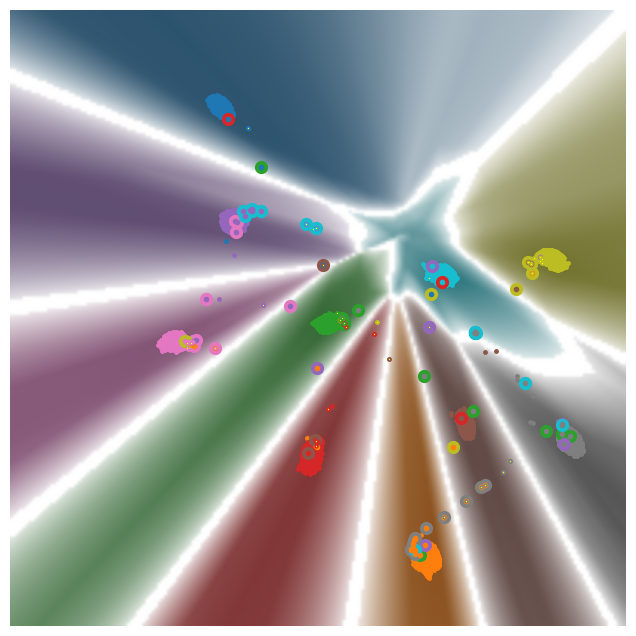

In [77]:
epoch = 15
from singleVis.visualizer_hlb_ import visualizer
border = data_provider.border_representation(epoch)
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi', device=DEVICE)  
vis = visualizer(data_provider, projector, 200, "tab10")
vis.savefig(epoch,path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, 'dvigrid')))


Successfully load the DVI visualization model for iteration 20
Computing decision regions ...
Successfully load the DVI visualization model for iteration 20
Successfully load the DVI visualization model for iteration 20


100%|██████████| 300/300 [00:00<00:00, 5505.25it/s]


Successfully load the DVI visualization model for iteration 20


100%|██████████| 300/300 [00:00<00:00, 6237.16it/s]


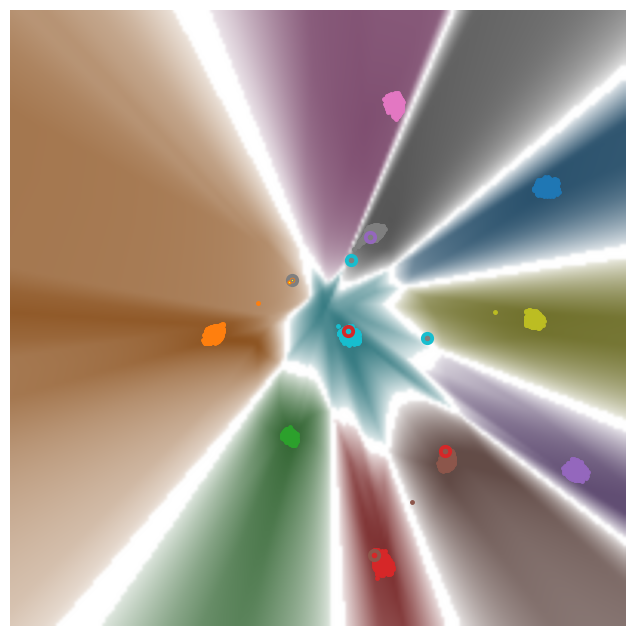

In [71]:
epoch = 20
from singleVis.visualizer_hlb_ import visualizer
border = data_provider.border_representation(epoch)
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi_init', device=DEVICE)  
vis = visualizer(data_provider, projector, 200, "tab10")
vis.savefig(epoch,path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, 'dvigrid')))


Successfully load the DVI visualization model for iteration 8
Computing decision regions ...
Successfully load the DVI visualization model for iteration 8
Successfully load the DVI visualization model for iteration 8


100%|██████████| 300/300 [00:00<00:00, 7751.49it/s]


Successfully load the DVI visualization model for iteration 8


100%|██████████| 300/300 [00:00<00:00, 7735.24it/s]


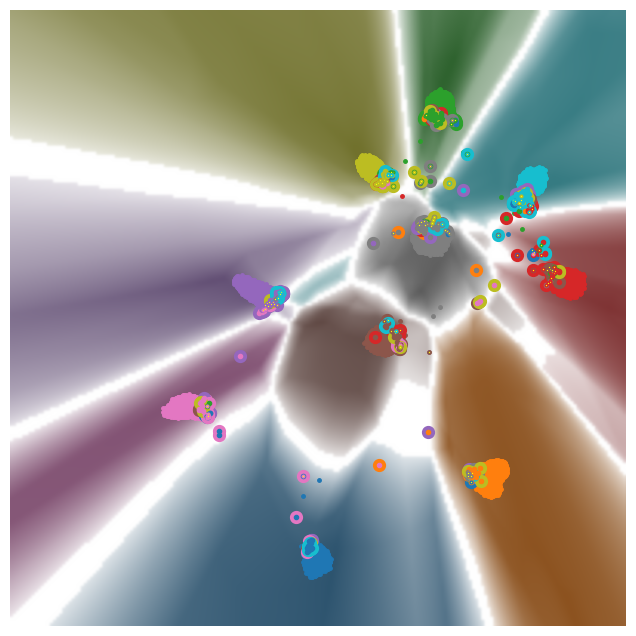

In [57]:
epoch = 8
from singleVis.visualizer_hlb_ import visualizer
border = data_provider.border_representation(epoch)
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi', device=DEVICE)  
vis = visualizer(data_provider, projector, 200, "tab10")
vis.savefig(epoch,path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, 'dvigrid')))


Successfully load the DVI visualization model for iteration 5
Computing decision regions ...
Successfully load the DVI visualization model for iteration 5
Successfully load the DVI visualization model for iteration 5


100%|██████████| 300/300 [00:00<00:00, 7727.35it/s]


Successfully load the DVI visualization model for iteration 5


100%|██████████| 300/300 [00:00<00:00, 7436.45it/s]


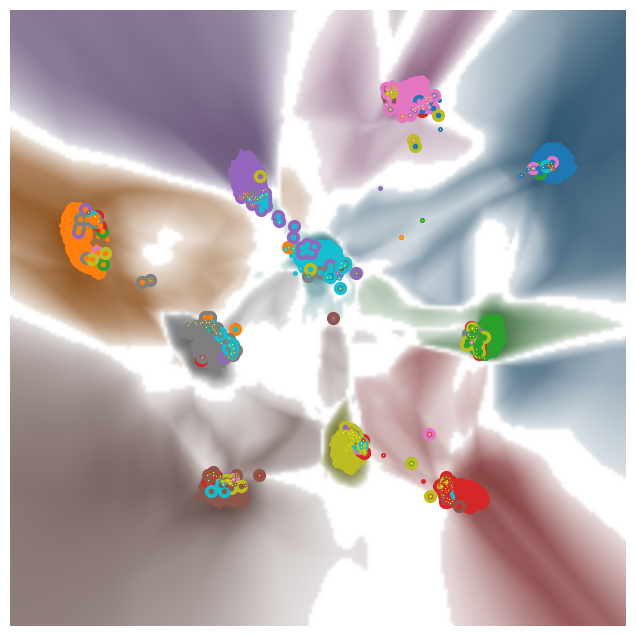

In [59]:
epoch = 5
from singleVis.visualizer_hlb_ import visualizer
border = data_provider.border_representation(epoch)
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='new_one', device=DEVICE)  
vis = visualizer(data_provider, projector, 200, "tab10")
vis.savefig(epoch,path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, 'dvigrid')))


Successfully load the DVI visualization model for iteration 8
Computing decision regions ...
Successfully load the DVI visualization model for iteration 8
Successfully load the DVI visualization model for iteration 8


100%|██████████| 300/300 [00:00<00:00, 7640.04it/s]


Successfully load the DVI visualization model for iteration 8


100%|██████████| 300/300 [00:00<00:00, 7576.51it/s]


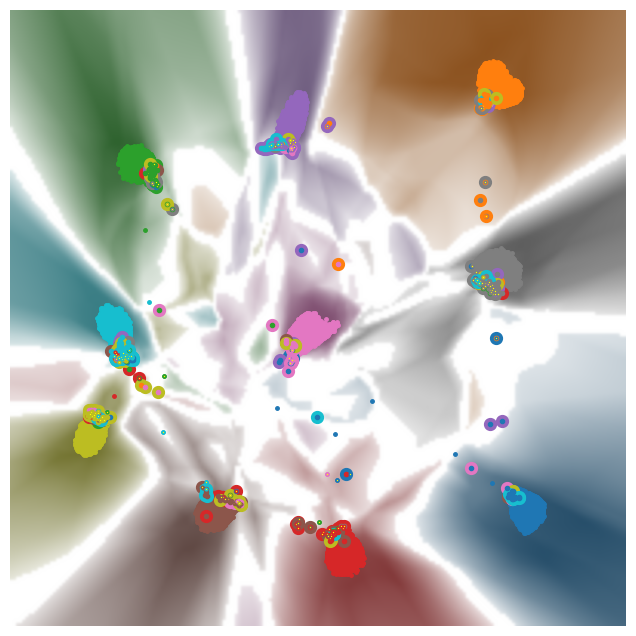

In [56]:
epoch = 8
from singleVis.visualizer_hlb_ import visualizer
border = data_provider.border_representation(epoch)
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='new_one', device=DEVICE)  
vis = visualizer(data_provider, projector, 200, "tab10")
vis.savefig(epoch,path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, 'dvigrid')))


In [40]:
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import check_random_state
from umap.umap_ import fuzzy_simplicial_set, make_epochs_per_sample

def if_border(data):
    mesh_preds = data_provider.get_pred(epoch, data)
    mesh_preds = mesh_preds + 1e-8

    sort_preds = np.sort(mesh_preds, axis=1)
    diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
    border = np.zeros(len(diff), dtype=np.uint8) + 0.05
    border[diff < 0.15] = 1
        
    return border
def _construct_boundary_wise_complex(train_data, border_centers):
        """compute the boundary wise complex
            for each border point, we calculate its k nearest train points
            for each train data, we calculate its k nearest border points
            for each boundary data in train data, we calculate its more nearest train + border poinst
        """
        train_border_index = if_border(train_data)
        train_data_non_border = train_data[train_border_index !=1]
        train_border = train_data[train_border_index ==1]
        

        
        fitting_data = np.concatenate((train_data_non_border,train_border, border_centers,train_border,train_border), axis=0)
        train_data = np.concatenate((train_data_non_border,train_border), axis=0)

        high_neigh = NearestNeighbors(n_neighbors=15, radius=0.4)
        high_neigh.fit(border_centers)
        
        knn_dists, knn_indices = high_neigh.kneighbors(train_data, n_neighbors=15, return_distance=True)

        # pred_dists = self.get_pred_diff(train_data,border_centers,knn_indices,epoch)
        # knn_dists = 1 * knn_dists + 1 * pred_dists

        knn_indices = knn_indices + len(train_data)
        


        high_bound_neigh = NearestNeighbors(n_neighbors=15, radius=0.4)
        high_bound_neigh.fit(train_data)
        
        # print("new_border_centers",len(new_border_centers),len(fitting_data))
        bound_knn_dists, bound_knn_indices = high_bound_neigh.kneighbors(border_centers, n_neighbors=15, return_distance=True)

        # bound_pred_dists = self.get_pred_diff(border_centers,train_data,bound_knn_indices,epoch)
        # bound_knn_dists = 1 * bound_knn_dists + 1 * bound_pred_dists


        train_high_bound_neigh = NearestNeighbors(n_neighbors=15, radius=0.4)

        train_high_bound_neigh.fit(train_data_non_border)
        tb_knn_dists, tb_knn_indices = high_neigh.kneighbors(train_border, n_neighbors=15, return_distance=True)

        train_high_bound_neigh_ = NearestNeighbors(n_neighbors=15, radius=0.4)
        train_high_bound_neigh_.fit(border_centers)
        tb_knn_dists_b, tb_knn_indices_b = high_neigh.kneighbors(train_border, n_neighbors=15, return_distance=True)

        tb_knn_indices_b = tb_knn_indices_b + len(train_data)

        knn_dists = np.concatenate((knn_dists, bound_knn_dists,tb_knn_dists,tb_knn_dists_b), axis=0)
        knn_indices = np.concatenate((knn_indices, bound_knn_indices,tb_knn_indices,tb_knn_indices_b), axis=0)

        random_state = check_random_state(None)
        bw_complex, sigmas, rhos = fuzzy_simplicial_set(
            X=fitting_data,
            n_neighbors=15,
            metric="euclidean",
            random_state=random_state,
            knn_indices=knn_indices,
            knn_dists=knn_dists
        )

        return bw_complex, sigmas, rhos, knn_indices

In [41]:
b, _,_,_ = _construct_boundary_wise_complex(train_data=data_provider.train_representation(epoch),border_centers=data_provider.border_representation(epoch))

100%|██████████| 300/300 [00:00<00:00, 7440.62it/s]


Successfully load the DVI visualization model for iteration 5
Computing decision regions ...
Successfully load the DVI visualization model for iteration 5
Successfully load the DVI visualization model for iteration 5


100%|██████████| 300/300 [00:00<00:00, 5237.73it/s]


Successfully load the DVI visualization model for iteration 5


100%|██████████| 300/300 [00:00<00:00, 5334.64it/s]


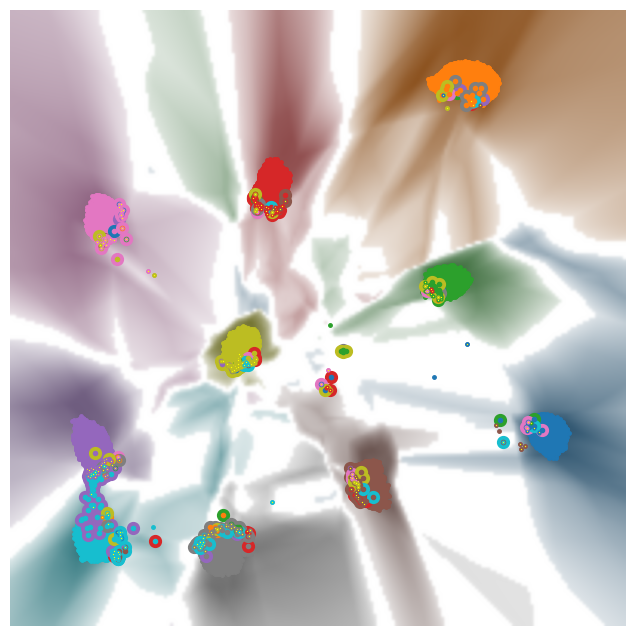

In [42]:
epoch = 5
from singleVis.visualizer_hlb_ import visualizer
border = data_provider.border_representation(epoch)
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='new_one', device=DEVICE)  
vis = visualizer(data_provider, projector, 200, "tab10")
vis.savefig(epoch,path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, 'dvigrid')))


Successfully load the DVI visualization model for iteration 5
Computing decision regions ...
Successfully load the DVI visualization model for iteration 5
Successfully load the DVI visualization model for iteration 5


100%|██████████| 300/300 [00:00<00:00, 3770.04it/s]


Successfully load the DVI visualization model for iteration 5


100%|██████████| 300/300 [00:00<00:00, 3921.77it/s]


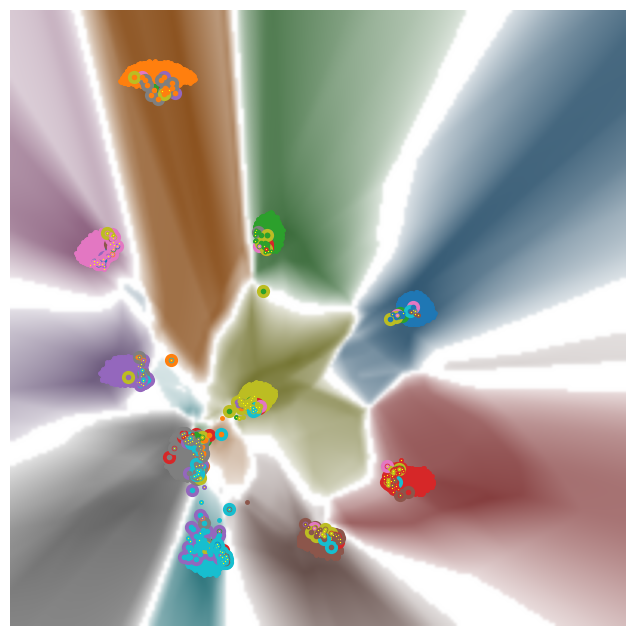

In [43]:
epoch = 5
from singleVis.visualizer_hlb_ import visualizer
border = data_provider.border_representation(epoch)
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi', device=DEVICE)  
vis = visualizer(data_provider, projector, 200, "tab10")
vis.savefig(epoch,path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, 'dvigrid')))


Successfully load the DVI visualization model for iteration 1
Computing decision regions ...
Successfully load the DVI visualization model for iteration 1
Successfully load the DVI visualization model for iteration 1


100%|██████████| 300/300 [00:00<00:00, 7306.51it/s]


Successfully load the DVI visualization model for iteration 1


100%|██████████| 300/300 [00:00<00:00, 7414.45it/s]


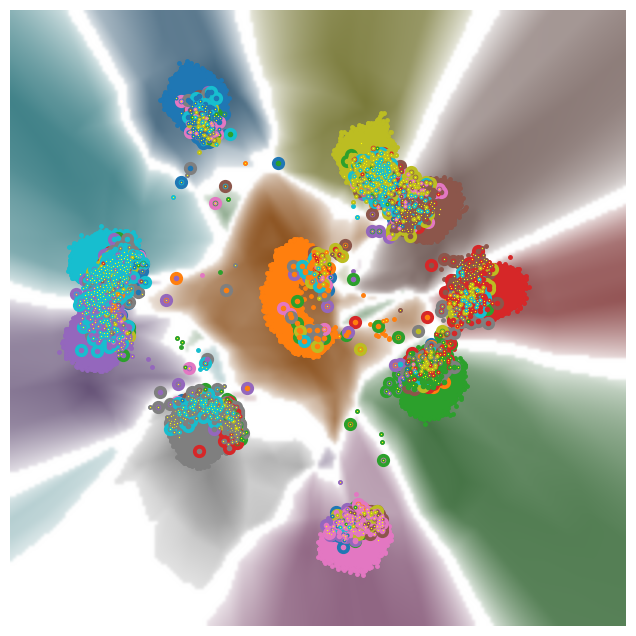

In [45]:
epoch = 1
from singleVis.visualizer_hlb_ import visualizer
border = data_provider.border_representation(epoch)
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi_init', device=DEVICE)  
vis = visualizer(data_provider, projector, 200, "tab10")
vis.savefig(epoch,path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, 'dvigrid')))


Successfully load the DVI visualization model for iteration 1
Computing decision regions ...
Successfully load the DVI visualization model for iteration 1
Successfully load the DVI visualization model for iteration 1


100%|██████████| 300/300 [00:00<00:00, 7729.82it/s]


Successfully load the DVI visualization model for iteration 1


100%|██████████| 300/300 [00:00<00:00, 7468.22it/s]


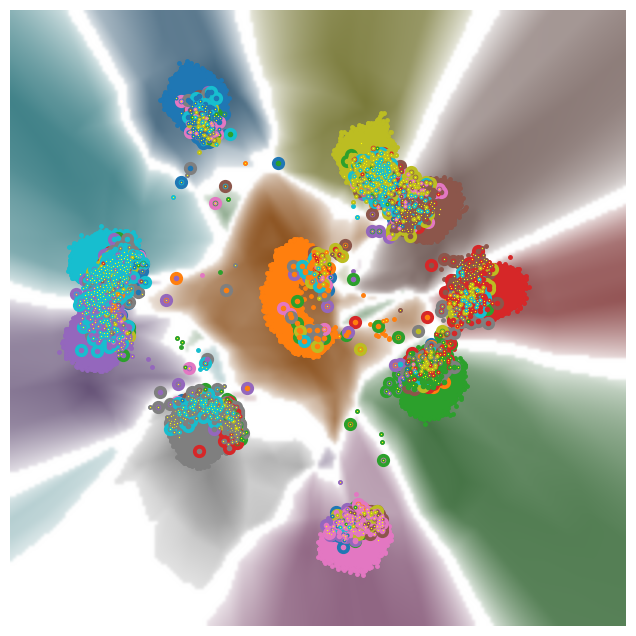

In [43]:
epoch = 1
from singleVis.visualizer_hlb_ import visualizer
border = data_provider.border_representation(epoch)
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi_init', device=DEVICE)  
vis = visualizer(data_provider, projector, 200, "tab10")
vis.savefig(epoch,path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, 'dvigrid')))


In [3]:
ENCODER_DIMS = [512, 256,2]

[512, 256, 128, 64, 2]

In [17]:
ENCODER_DIMS = [512, 256,2] 
DECODER_DIMS = [2, 256, 512] 
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

100%|██████████| 30/30 [00:00<00:00, 2187.15it/s]


Successfully load the DVI visualization model for iteration 15
Successfully load the DVI visualization model for iteration 15
Computing decision regions ...
Successfully load the DVI visualization model for iteration 15
Successfully load the DVI visualization model for iteration 15
grid_samples (40000, 512)


100%|██████████| 30/30 [00:00<00:00, 1730.32it/s]


Successfully load the DVI visualization model for iteration 15


100%|██████████| 30/30 [00:00<00:00, 2285.85it/s]


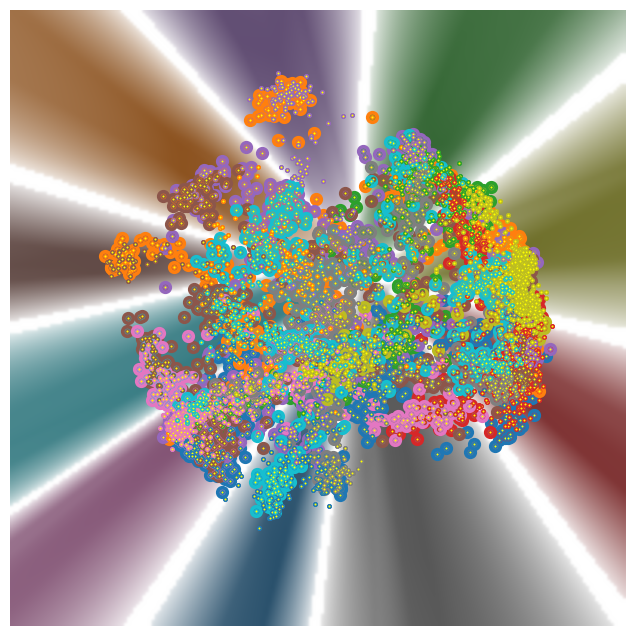

In [5]:
epoch = 15
def if_border(data):
    mesh_preds = data_provider.get_pred(epoch, data)
    mesh_preds = mesh_preds + 1e-8

    sort_preds = np.sort(mesh_preds, axis=1)
    diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
    border = np.zeros(len(diff), dtype=np.uint8) + 0.05
    border[diff < 0.15] = 1
        
    return border
from trustVis.data_generation import DataGeneration
dataGeneration = DataGeneration(net, data_provider,epoch,data_provider.DEVICE)

        # _,adv_X = dataGeneration.gen(epsilon=0.1,sample_ratio=0.5)
        # border_elements = np.load(os.path.join(self.data_provider.content_path,"Model", "Epoch_{:d}".format(self.iteration-1), "border_centers.npy"))
# border_elements = dataGeneration.get_near_epoch_border(epoch)
borders = data_provider.border_representation(epoch)
# let's assume X is your data
noise_scale = 0.05
noise = np.random.normal(loc=0, scale=noise_scale, size=borders.shape)
X_perturbed = borders + noise

border = if_border(X_perturbed)
border_elements_emd = projector.batch_project(epoch, X_perturbed)
vis.show_grid_embedding(epoch=epoch, data=X_perturbed, border=border, embedding=border_elements_emd, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

100%|██████████| 30/30 [00:00<00:00, 1177.55it/s]


Successfully load the DVI visualization model for iteration 8
Successfully load the DVI visualization model for iteration 8
Computing decision regions ...
Successfully load the DVI visualization model for iteration 8
Successfully load the DVI visualization model for iteration 8
grid_samples (40000, 512)


100%|██████████| 30/30 [00:00<00:00, 699.61it/s]


Successfully load the DVI visualization model for iteration 8


100%|██████████| 30/30 [00:00<00:00, 1016.80it/s]


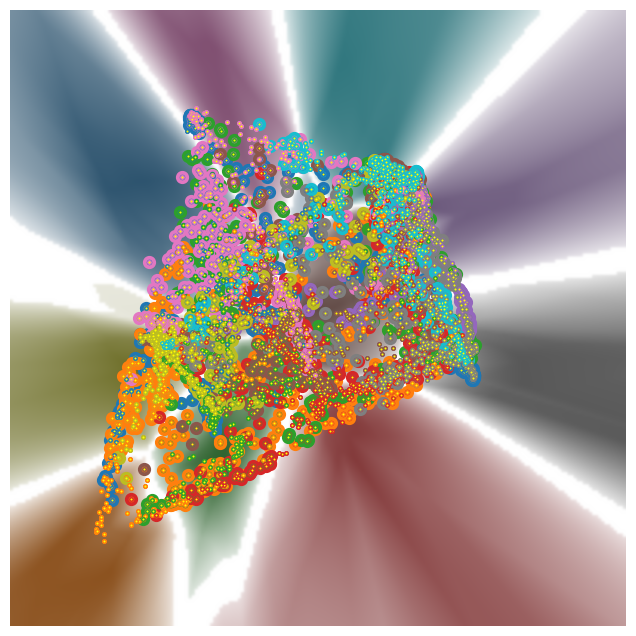

In [6]:
epoch = 8
def if_border(data):
    mesh_preds = data_provider.get_pred(epoch, data)
    mesh_preds = mesh_preds + 1e-8

    sort_preds = np.sort(mesh_preds, axis=1)
    diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
    border = np.zeros(len(diff), dtype=np.uint8) + 0.05
    border[diff < 0.15] = 1
        
    return border
from trustVis.data_generation import DataGeneration
dataGeneration = DataGeneration(net, data_provider,epoch,data_provider.DEVICE)

        # _,adv_X = dataGeneration.gen(epsilon=0.1,sample_ratio=0.5)
        # border_elements = np.load(os.path.join(self.data_provider.content_path,"Model", "Epoch_{:d}".format(self.iteration-1), "border_centers.npy"))
# border_elements = dataGeneration.get_near_epoch_border(epoch)
borders = data_provider.border_representation(epoch)
# let's assume X is your data
noise_scale = 0.05
noise = np.random.normal(loc=0, scale=noise_scale, size=borders.shape)
X_perturbed = borders + noise

border = if_border(X_perturbed)
border_elements_emd = projector.batch_project(epoch, X_perturbed)
vis.show_grid_embedding(epoch=epoch, data=X_perturbed, border=border, embedding=border_elements_emd, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

Successfully load the DVI visualization model for iteration 8


100%|██████████| 30/30 [00:00<00:00, 7005.30it/s]

Successfully load the DVI visualization model for iteration 8


Computing decision regions ...
Successfully load the DVI visualization model for iteration 8
Successfully load the DVI visualization model for iteration 8
grid_samples (40000, 512)


100%|██████████| 30/30 [00:00<00:00, 1254.04it/s]


Successfully load the DVI visualization model for iteration 8


100%|██████████| 30/30 [00:00<00:00, 1316.49it/s]


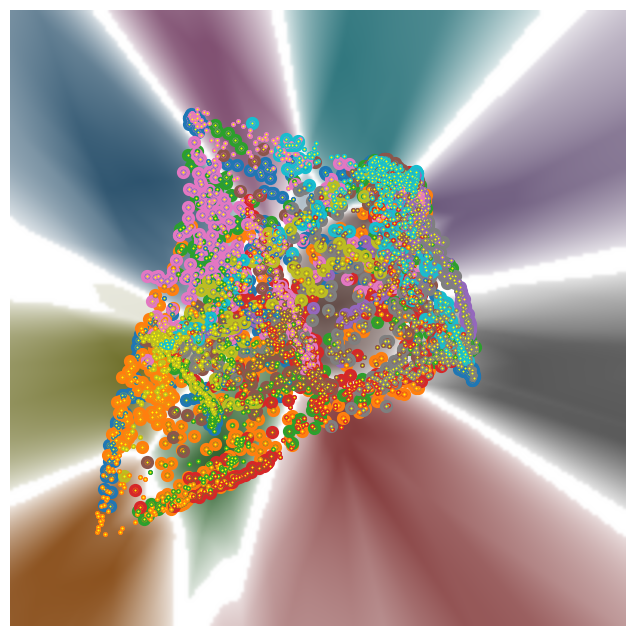

In [10]:
# let's assume X is your data

borders_center = data_provider.border_representation(epoch)
border_elements_emd = projector.batch_project(epoch, borders)

border = if_border(borders)

vis.show_grid_embedding(epoch=epoch, data=borders_center, border=border, embedding=border_elements_emd, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

Successfully load the DVI visualization model for iteration 5
Computing decision regions ...
Successfully load the DVI visualization model for iteration 5
Successfully load the DVI visualization model for iteration 5


100%|██████████| 300/300 [00:00<00:00, 7707.43it/s]


Successfully load the DVI visualization model for iteration 5


100%|██████████| 300/300 [00:00<00:00, 7354.60it/s]


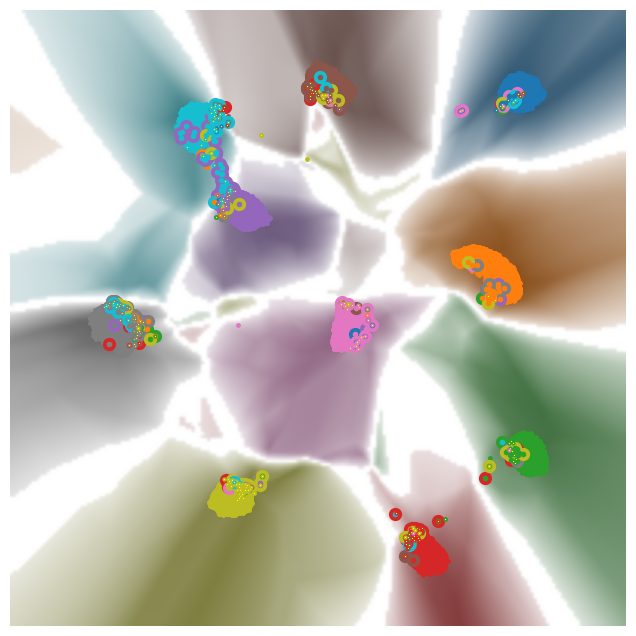

In [20]:
epoch = 5
from singleVis.visualizer_hlb_ import visualizer
border = data_provider.border_representation(epoch)
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi', device=DEVICE)  
vis = visualizer(data_provider, projector, 200, "tab10")
vis.savefig(epoch,path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, 'dvigrid')))


In [13]:
from sklearn.neighbors import NearestNeighbors
high_neigh = NearestNeighbors(n_neighbors=15, radius=0.4)
border_centers = data_provider.border_representation(epoch)
train_data = data_provider.train_representation(epoch)
high_neigh.fit(border_centers)
        
knn_dists, knn_indices = high_neigh.kneighbors(train_data, n_neighbors=15, return_distance=True)

In [17]:
pred  = data_provider.get_pred(epoch, train_data)
new_l =[]
for i in range(len(knn_indices)):
    pred_i = pred[knn_indices[i]]
    # pred_diff = np.linalg.norm(pred_i - pred[i]) 
    pred_diff = np.mean(np.abs(pred_i - pred[i]), axis=-1) #
    pred_diff = np.exp(pred_diff) - 1  # amplify the difference
    new_l.append(pred_diff)
new_l = np.array(new_l)
combined_dists = knn_dists + new_l

100%|██████████| 300/300 [00:00<00:00, 4077.06it/s]


In [16]:
a = [2.7724051 , 2.9528718 , 1.5321717 , 2.730715]

In [19]:
knn_dists

array([[ 9.4367695,  9.804239 , 10.152048 , ..., 10.618909 , 10.646381 ,
        10.734486 ],
       [14.745446 , 14.834238 , 14.878247 , ..., 15.605195 , 15.634153 ,
        15.639917 ],
       [12.0809555, 12.126398 , 12.386222 , ..., 12.761507 , 12.838259 ,
        12.872057 ],
       ...,
       [13.264561 , 13.549872 , 13.6471195, ..., 14.3668995, 14.386362 ,
        14.388215 ],
       [12.500431 , 12.510655 , 12.712918 , ..., 13.278949 , 13.338601 ,
        13.345699 ],
       [12.247486 , 12.502982 , 12.530805 , ..., 13.242759 , 13.284518 ,
        13.292814 ]], dtype=float32)

In [18]:
new_l

array([[14.997064  , 18.1609    ,  3.6282172 , ..., 14.343856  ,
        20.854572  ,  8.486135  ],
       [11.912113  ,  8.1523075 , 11.005692  , ...,  1.8505282 ,
         0.33708107, 14.769096  ],
       [ 0.6137006 ,  9.414397  ,  0.63968   , ..., 10.139296  ,
         8.6451    , 14.242204  ],
       ...,
       [ 0.5450922 , 21.588888  , 12.693955  , ..., 10.952094  ,
        11.560802  , 15.35685   ],
       [12.305261  ,  6.149515  ,  0.79154384, ..., 16.280512  ,
         9.094188  ,  8.334936  ],
       [ 8.571606  ,  1.077498  , 13.484209  , ...,  8.897254  ,
        13.034848  ,  9.406487  ]], dtype=float32)

In [15]:
new_l

array([[2.7724051 , 2.9528718 , 1.5321717 , ..., 2.730715  , 3.0844102 ,
        2.2498312 ],
       [2.5581658 , 2.214006  , 2.485381  , ..., 1.0475044 , 0.29048893,
        2.758052  ],
       [0.47853008, 2.3431892 , 0.49450105, ..., 2.410479  , 2.26645   ,
        2.7240682 ],
       ...,
       [0.43508357, 3.117458  , 2.6169546 , ..., 2.4809065 , 2.530581  ,
        2.7946467 ],
       [2.5881596 , 1.9670446 , 0.5830778 , ..., 2.8495793 , 2.3119597 ,
        2.233764  ],
       [2.258801  , 0.7311642 , 2.673059  , ..., 2.2922573 , 2.6415434 ,
        2.3424294 ]], dtype=float32)

In [31]:
# import torch
# import numpy as np

# def generate_adversarial_examples_50_50(model, input_x, predictions, num_samples, device):
#     '''Generate adversarial examples where top two predicted classes are from selected two classes
#     and both have prediction probabilities around 0.5
#     :param model: The model to attack.
#     :param input_x: images, torch.Tensor of shape (N, C, H, W)
#     :param predictions: class prediction, numpy.ndarray of shape (N,)
#     :param num_samples: The number of adversarial examples to generate.
#     :param device: The device to run code, torch cpu or torch cuda.
#     :return: A list of adversarial examples.
#     '''
#     model.eval()
#     adversarial_examples = []
#     unique_classes = np.unique(predictions)

#     while len(adversarial_examples) < num_samples:
#         # randomly select two different classes
#         class1, class2 = np.random.choice(unique_classes, size=2, replace=False)

#         # find data points belong to these two classes
#         data_points_class1 = input_x[predictions == class1]
#         data_points_class2 = input_x[predictions == class2]

#         # randomly select a data point from each class
#         data1 = data_points_class1[np.random.choice(len(data_points_class1))]
#         data2 = data_points_class2[np.random.choice(len(data_points_class2))]

#         data1 = data1.to(device)
#         data2 = data2.to(device)

#         for _ in range(100):  # perform 100 trials
#             lamb = np.random.rand()  # random interpolation factor for diversity
#             data_mix = lamb * data1 + (1 - lamb) * data2  # interpolated data point
#             pred = torch.nn.functional.softmax(model(data_mix.unsqueeze(0)), dim=1)
#             sorted_pred, indices = torch.sort(pred, descending=True)

#             # check if top two classes are class1 and class2 and probabilities are around 0.5
#             if set(indices[0, :2].tolist()) == set([class1, class2]) and \
#                 0.4 <= sorted_pred[0, 0].item() <= 0.6 and 0.4 <= sorted_pred[0, 1].item() <= 0.6:
#                 adversarial_examples.append(data_mix)
#                 break  # break the loop if we found a valid adversarial example

#     return torch.stack(adversarial_examples)


In [52]:
import itertools
import tqdm
def generate_adversarial_examples_50_50(model, input_x, predictions, device, num_examples=100):
    '''Generate adversarial examples where top two predicted classes are from selected two classes
    and both have prediction probabilities around 0.5
    :param model: The model to attack.
    :param input_x: images, torch.Tensor of shape (N, C, H, W)
    :param predictions: class prediction, numpy.ndarray of shape (N,)
    :param device: The device to run code, torch cpu or torch cuda.
    :param num_examples: Number of adversarial examples to generate for each pair of classes.
    :return: A list of adversarial examples.
    '''
    model.eval()
    adversarial_examples = []
    unique_classes = np.unique(predictions)

    # loop through all possible pairs of unique classes
    for class1, class2 in itertools.combinations(unique_classes, 2):

        # find data points belong to these two classes
        data_points_class1 = input_x[predictions == class1]
        data_points_class2 = input_x[predictions == class2]

        # randomly select a data point from each class
        data1 = data_points_class1[np.random.choice(len(data_points_class1))]
        data2 = data_points_class2[np.random.choice(len(data_points_class2))]

        data1 = data1.to(device)
        data2 = data2.to(device)

        

        num_successes = 0
        pbar = tqdm.tqdm(total=num_examples, desc="Generating adversarial examples")
        for _ in range(1000):  # perform 1000 trials, change this number if needed
            lamb = np.random.rand()  # random interpolation factor for diversity
            data_mix = lamb * data1 + (1 - lamb) * data2  # interpolated data point
            pred = torch.nn.functional.softmax(model(data_mix.unsqueeze(0)), dim=1)
            sorted_pred, indices = torch.sort(pred, descending=True)

            # check if top two classes are class1 and class2 and probabilities are around 0.5
            if set(indices[0, :2].tolist()) == set([class1, class2]) and \
                0.4 <= sorted_pred[0, 0].item() <= 0.6 and 0.4 <= sorted_pred[0, 1].item() <= 0.6:
                adversarial_examples.append(data_mix)
                num_successes += 1
                pbar.update(1)
                if num_successes >= num_examples:  # if we have generated enough examples
                    break  # break the loop
    pbar.close()
    return adversarial_examples


In [32]:
training_data_path = os.path.join(data_provider.content_path, "Training_data")
training_data = torch.load(os.path.join(training_data_path, "training_dataset_data.pth"),
                                   map_location="cpu")
training_data = training_data.to(DEVICE)
mesh_preds = data_provider.get_pred(epoch, data_provider.train_representation(epoch)).argmax(axis=1)

In [53]:

adv = generate_adversarial_examples_50_50(net,training_data, mesh_preds, DEVICE)

Generating adversarial examples:   0%|          | 0/100 [00:02<?, ?it/s]


Generating adversarial examples:   0%|          | 0/100 [00:02<?, ?it/s]


In [54]:
def feature_function(model,epoch):
    model_path = os.path.join(data_provider.content_path, "Model")
    model_location = os.path.join(model_path, "{}_{:d}".format('Epoch', epoch), "subject_model.pth")
    model.load_state_dict(torch.load(model_location, map_location=torch.device("cpu")))
    model = model.to(DEVICE)
    model.eval()
    fea_fn = model.feature
    return fea_fn

In [56]:
adv[0].shape

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [ ]:
adv = torch.Tensor()

In [1]:
from singleVis.utils import *
repr_model = feature_function(net, epoch)
adv_centers = batch_run(repr_model, torch.stack(adv))

ModuleNotFoundError: No module named 'singleVis'

In [45]:
adv = adv.cpu().detach().numpy()

def if_border(data):
    mesh_preds = data_provider.get_pred(epoch, data)
    mesh_preds = mesh_preds + 1e-8

    sort_preds = np.sort(mesh_preds, axis=1)
    diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
    border = np.zeros(len(diff), dtype=np.uint8) + 0.05
    border[diff < 0.15] = 1
        
    return border
from trustVis.data_generation import DataGeneration
dataGeneration = DataGeneration(net, data_provider,epoch,data_provider.DEVICE)

        # _,adv_X = dataGeneration.gen(epsilon=0.1,sample_ratio=0.5)

border = if_border(adv_centers)
border_elements_emd = projector.batch_project(epoch, adv)
vis.show_grid_embedding(epoch=epoch, data=adv_centers, border=border, embedding=border_elements_emd, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

AttributeError: 'list' object has no attribute 'cpu'

RuntimeError: Error(s) in loading state_dict for VisModel:
	size mismatch for encoder.2.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for encoder.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.4.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for encoder.4.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.6.weight: copying a param with shape torch.Size([2, 64]) from checkpoint, the shape in current model is torch.Size([2, 256]).
	size mismatch for decoder.0.weight: copying a param with shape torch.Size([64, 2]) from checkpoint, the shape in current model is torch.Size([256, 2]).
	size mismatch for decoder.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for decoder.2.weight: copying a param with shape torch.Size([128, 64]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for decoder.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for decoder.4.weight: copying a param with shape torch.Size([256, 128]) from checkpoint, the shape in current model is torch.Size([256, 256]).

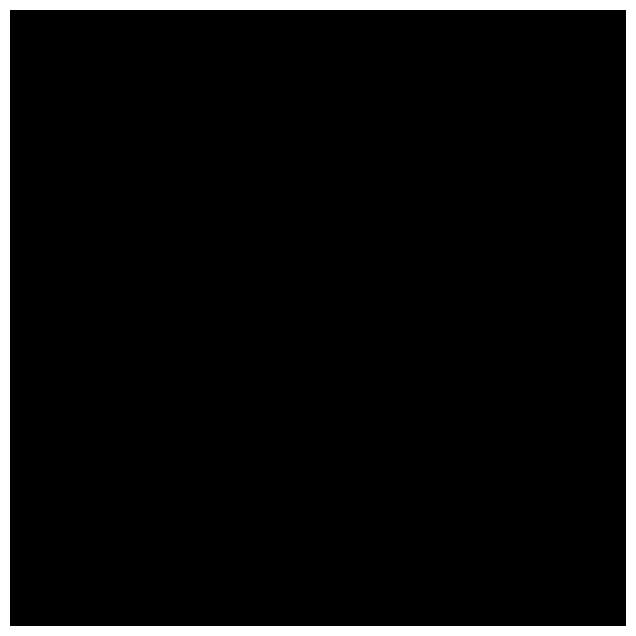

In [34]:
epoch = 1
from singleVis.visualizer_hlb_ import visualizer
border = data_provider.border_representation(epoch)
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi', device=DEVICE)  
vis = visualizer(data_provider, projector, 200, "tab10")
vis.savefig(epoch,path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, 'dvigrid')))


100%|██████████| 30/30 [00:00<00:00, 258.19it/s]


In [3]:
epoch = 1

In [5]:

from singleVis.SingleVisualizationModel import VisModel
from singleVis.spatial_edge_constructor import SingleEpochSpatialEdgeConstructorForGrid

pre_model = VisModel(ENCODER_DIMS, DECODER_DIMS)
file_path = os.path.join(CONTENT_PATH, "Model", "Epoch_{}".format(epoch), "{}.pth".format('dvi'))
save_model = torch.load(file_path, map_location="cpu")
pre_model.load_state_dict(save_model["state_dict"])
pre_model.to(DEVICE)

VisModel(
  (encoder): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
  )
)

In [6]:
"""get high dimensional grid, 2d grid embedding and border vector"""

projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi', device=DEVICE)  
vis = visualizer(data_provider, projector, 200, "tab10")
grid_high, grid_emd ,border = vis.get_epoch_decision_view(epoch,200,None, True)
train_data_embedding = projector.batch_project(epoch, data_provider.train_representation(epoch))
from sklearn.neighbors import NearestNeighbors
import numpy as np

# 假设 train_data_embedding 和 grid_emd 都是 numpy arrays，每一行都是一个点
threshold = 2  # 设置你的阈值

# 使用 train_data_embedding 初始化 NearestNeighbors 对象
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(train_data_embedding)
# 对于 grid_emd 中的每一个点，找到 train_data_embedding 中离它最近的点
distances, indices = nbrs.kneighbors(grid_emd)
# 找到距离小于阈值的索引
mask = distances.ravel() < threshold
selected_indices = np.arange(grid_emd.shape[0])[mask]

border_indices = np.arange(grid_emd.shape[0])[border==1]
union_indices = np.union1d(selected_indices, border_indices)

Computing decision regions ...
Successfully load the DVI visualization model for iteration 1


Successfully load the DVI visualization model for iteration 1


100%|██████████| 200/200 [00:00<00:00, 9893.98it/s]

Successfully load the DVI visualization model for iteration 1


In [30]:
import time
# train_list =  union_indices

optimizer = torch.optim.Adam(pre_model.parameters(), lr=.01, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=.1)

border_centers = data_provider.border_representation(epoch)
fitting_data = np.concatenate((grid_high, border_centers), axis=0)
# fitting_data = grid_high[selected_indices]
print("fitting_data",fitting_data.shape)


# Define Edge dataset
t0 = time.time()
###### all grid + training 
# N_NEIGHBORS = 30
spatial_cons = SingleEpochSpatialEdgeConstructorForGrid(data_provider, border_centers, epoch, S_N_EPOCHS, B_N_EPOCHS, N_NEIGHBORS,only_grid=False)
###### only grid 
# spatial_cons = SingleEpochSpatialEdgeConstructorForGrid(data_provider, grid_high[union_indices], epoch, S_N_EPOCHS, B_N_EPOCHS, N_NEIGHBORS,only_grid=True)
edge_to, edge_from, probs, feature_vectors, attention = spatial_cons.construct()
t1 = time.time()
from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.SingleVisualizationModel import VisModel
from singleVis.losses import UmapLoss, ReconstructionLoss, TemporalLoss, DVILoss, SingleVisLoss, DummyTemporalLoss
from singleVis.edge_dataset import DVIDataHandler
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import DataLoader
probs = probs / (probs.max()+1e-3)
eliminate_zeros = probs>5e-2    #1e-3
edge_to = edge_to[eliminate_zeros]
edge_from = edge_from[eliminate_zeros]
probs = probs[eliminate_zeros]
dataset = DVIDataHandler(edge_to, edge_from, feature_vectors, attention)

n_samples = int(np.sum(S_N_EPOCHS * probs) // 1)
# chose sampler based on the number of dataset
if len(edge_to) > pow(2,24):
    sampler = CustomWeightedRandomSampler(probs, n_samples, replacement=True)
else:
    sampler = WeightedRandomSampler(probs, n_samples, replacement=True)
edge_loader = DataLoader(dataset, batch_size=2000, sampler=sampler, num_workers=8, prefetch_factor=10)
from umap.umap_ import find_ab_params
temporal_loss_fn = DummyTemporalLoss(DEVICE)
# LAMBDA1 = 3
# Define Losses
negative_sample_rate = 5
min_dist = .1
_a, _b = find_ab_params(1.0, min_dist)
umap_loss_fn = UmapLoss(negative_sample_rate, DEVICE, _a, _b, repulsion_strength=1.0)
recon_loss_fn = ReconstructionLoss(beta=1.0)
single_loss_fn = SingleVisLoss(umap_loss_fn, recon_loss_fn, lambd=LAMBDA1)
criterion = DVILoss(umap_loss_fn, recon_loss_fn, temporal_loss_fn, lambd1=LAMBDA1, lambd2=0.0,device=DEVICE)

NameError: name 'pre_model' is not defined

In [36]:

from singleVis.trainer import SingleVisTrainer
from tqdm import tqdm
from singleVis.losses import PositionRecoverLoss

def disable_grad(model):
    for param in model.parameters():
        param.requires_grad = False   
        
class DVIReFineTrainer(SingleVisTrainer):
    def __init__(self, model, criterion, optimizer, lr_scheduler, edge_loader, DEVICE,data, disable_encoder_grad=False, **kwargs):
        super().__init__(model, criterion, optimizer, lr_scheduler, edge_loader, DEVICE, **kwargs)
        self.disable_encoder_grad = disable_encoder_grad
        self.data = data
        
    def train(self, PATIENT, MAX_EPOCH_NUMS):
        patient = PATIENT
        print("patient",patient)
        time_start = time.time()
        for epoch in range(MAX_EPOCH_NUMS):
            print("====================\nepoch:{}\n===================".format(epoch+1))
            prev_loss = self.loss
            loss = self.train_step()
            self.lr_scheduler.step()
            # early stop, check whether converge or not
            if prev_loss - loss < 5E-3:
                if patient == 0:
                    break
                else:
                    patient -= 1
            else:
                patient = PATIENT

        time_end = time.time()
        time_spend = time_end - time_start
        print("Time spend: {:.2f} for training vis model...".format(time_spend))
    
    def train_step(self):
        
        self.model = self.model.to(device=self.DEVICE)
        ####### disable encoder
        if self.disable_encoder_grad == True:
            disable_grad(self.model.encoder)

        self.model.train()
        all_loss = []
        umap_losses = []
        recon_losses = []
        temporal_losses = []
        recoverposition_losses = []
        # loss_fn = PositionRecoverLoss()

        t = tqdm(self.edge_loader, leave=True, total=len(self.edge_loader))
        
        for data in t:
            edge_to, edge_from, a_to, a_from = data

            edge_to = edge_to.to(device=self.DEVICE, dtype=torch.float32)
            edge_from = edge_from.to(device=self.DEVICE, dtype=torch.float32)
            a_to = a_to.to(device=self.DEVICE, dtype=torch.float32)
            a_from = a_from.to(device=self.DEVICE, dtype=torch.float32)

            outputs = self.model(edge_to, edge_from)
            umap_l, recon_l, temporal_l, loss = self.criterion(edge_to, edge_from, a_to, a_from, self.model, outputs)
            data = torch.Tensor(self.data).to(self.DEVICE)
            new_emb = self.model.encoder(data).to(self.DEVICE)
            grid_high = self.model.decoder(torch.Tensor(new_emb).to(self.DEVICE))
           

            pos_recover_loss_fn = PositionRecoverLoss(self.DEVICE)

            pos_loss = pos_recover_loss_fn(torch.Tensor(grid_high).to(self.DEVICE), torch.Tensor(self.data).to(self.DEVICE))

            all_loss.append(loss.mean().item())
            umap_losses.append(umap_l.item())
            recon_losses.append(recon_l.item())
            temporal_losses.append(temporal_l.mean().item())
            recoverposition_losses.append(pos_loss.mean().item())
            # ===================backward====================
            recoverposition_loss = sum(recoverposition_losses) / len(recoverposition_losses)
            loss_new = loss + 10 * recoverposition_loss
            self.optimizer.zero_grad()
            loss_new.mean().backward()
            # pos_loss.mean().backward()
            self.optimizer.step()
        self._loss = sum(all_loss) / len(all_loss)
        self.model.eval()
        print('umap:{:.4f}\trecon_l:{:.4f}\ttemporal_l:{:.4f}\tloss:{:.4f}\tecoverposition_losses:{}'.format(sum(umap_losses) / len(umap_losses),
                                                                sum(recon_losses) / len(recon_losses),
                                                                sum(temporal_losses) / len(temporal_losses),
                                                                sum(all_loss) / len(all_loss), sum(recoverposition_losses) / len(all_loss)))
        return self.loss
    
    def record_time(self, save_dir, file_name, operation, iteration, t):
        # save result
        save_file = os.path.join(save_dir, file_name+".json")
        if not os.path.exists(save_file):
            evaluation = dict()
        else:
            f = open(save_file, "r")
            evaluation = json.load(f)
            f.close()
        if operation not in evaluation.keys():
            evaluation[operation] = dict()
        evaluation[operation][iteration] = round(t, 3)
        with open(save_file, 'w') as f:
            json.dump(evaluation, f)

In [35]:
# from singleVis.trainer import DVIReFineTrainer
trainer = DVIReFineTrainer(pre_model, criterion, optimizer, lr_scheduler, edge_loader, DEVICE, data_provider.border_representation(epoch), disable_encoder_grad = True)

t2=time.time()
trainer.train(15, MAX_EPOCH)
t3 = time.time()

    # save result
save_dir = data_provider.model_path
trainer.record_time(save_dir, "time_{}".format(VIS_MODEL_NAME), "complex_construction", str(epoch), t1-t0)
trainer.record_time(save_dir, "time_{}".format(VIS_MODEL_NAME), "training", str(epoch), t3-t2)
save_dir = os.path.join(data_provider.model_path, "Epoch_{}".format(epoch))
trainer.save(save_dir=save_dir, file_name="{}".format('dvi_grid_b'))

print("Finish epoch {}...".format(epoch))

patient 15
epoch:1


100%|██████████| 2179/2179 [00:31<00:00, 69.57it/s]


umap:0.1389	recon_l:0.5209	temporal_l:0.0000	loss:0.6599	ecoverposition_losses:0.6050701728924089
epoch:2


100%|██████████| 2179/2179 [00:31<00:00, 68.61it/s]


umap:0.1389	recon_l:0.5178	temporal_l:0.0000	loss:0.6567	ecoverposition_losses:0.5962232862825293
epoch:3


100%|██████████| 2179/2179 [00:31<00:00, 68.73it/s]


umap:0.1390	recon_l:0.5175	temporal_l:0.0000	loss:0.6565	ecoverposition_losses:0.5952257942639124
epoch:4


100%|██████████| 2179/2179 [00:31<00:00, 68.73it/s]


umap:0.1388	recon_l:0.5172	temporal_l:0.0000	loss:0.6561	ecoverposition_losses:0.5947724238017548
epoch:5


100%|██████████| 2179/2179 [00:31<00:00, 69.55it/s]


umap:0.1390	recon_l:0.5116	temporal_l:0.0000	loss:0.6505	ecoverposition_losses:0.59315293964414
epoch:6


100%|██████████| 2179/2179 [00:31<00:00, 68.56it/s]


umap:0.1390	recon_l:0.5115	temporal_l:0.0000	loss:0.6505	ecoverposition_losses:0.5924726144990663
epoch:7


100%|██████████| 2179/2179 [00:31<00:00, 69.15it/s]


umap:0.1389	recon_l:0.5112	temporal_l:0.0000	loss:0.6501	ecoverposition_losses:0.5921735734280887
epoch:8


100%|██████████| 2179/2179 [00:31<00:00, 68.85it/s]


umap:0.1390	recon_l:0.5109	temporal_l:0.0000	loss:0.6499	ecoverposition_losses:0.5917098257398321
epoch:9


100%|██████████| 2179/2179 [00:31<00:00, 69.90it/s]


umap:0.1390	recon_l:0.5098	temporal_l:0.0000	loss:0.6488	ecoverposition_losses:0.5913296337245856
epoch:10


100%|██████████| 2179/2179 [00:31<00:00, 69.85it/s]


umap:0.1389	recon_l:0.5098	temporal_l:0.0000	loss:0.6486	ecoverposition_losses:0.5913524815334864
epoch:11


100%|██████████| 2179/2179 [00:31<00:00, 68.96it/s]


umap:0.1390	recon_l:0.5099	temporal_l:0.0000	loss:0.6489	ecoverposition_losses:0.5912783468136168
epoch:12


100%|██████████| 2179/2179 [00:31<00:00, 68.61it/s]


umap:0.1390	recon_l:0.5097	temporal_l:0.0000	loss:0.6487	ecoverposition_losses:0.5912393154272961
epoch:13


100%|██████████| 2179/2179 [00:31<00:00, 69.28it/s]


umap:0.1390	recon_l:0.5096	temporal_l:0.0000	loss:0.6486	ecoverposition_losses:0.5911349039276896
epoch:14


100%|██████████| 2179/2179 [00:31<00:00, 69.09it/s]


umap:0.1390	recon_l:0.5097	temporal_l:0.0000	loss:0.6486	ecoverposition_losses:0.5910944391303568
epoch:15


100%|██████████| 2179/2179 [00:31<00:00, 70.25it/s]


umap:0.1389	recon_l:0.5097	temporal_l:0.0000	loss:0.6487	ecoverposition_losses:0.5911158066432702
epoch:16


100%|██████████| 2179/2179 [00:31<00:00, 69.10it/s]


umap:0.1390	recon_l:0.5097	temporal_l:0.0000	loss:0.6487	ecoverposition_losses:0.5911289400439461
epoch:17


100%|██████████| 2179/2179 [00:31<00:00, 69.24it/s]


umap:0.1391	recon_l:0.5097	temporal_l:0.0000	loss:0.6487	ecoverposition_losses:0.5911345430173257
epoch:18


100%|██████████| 2179/2179 [00:32<00:00, 67.78it/s]


umap:0.1389	recon_l:0.5097	temporal_l:0.0000	loss:0.6486	ecoverposition_losses:0.5911337729165619
epoch:19


100%|██████████| 2179/2179 [00:31<00:00, 69.54it/s]


umap:0.1389	recon_l:0.5097	temporal_l:0.0000	loss:0.6486	ecoverposition_losses:0.5911368619635216
epoch:20


100%|██████████| 2179/2179 [00:31<00:00, 68.79it/s]

umap:0.1389	recon_l:0.5096	temporal_l:0.0000	loss:0.6486	ecoverposition_losses:0.5911392597716683
Time spend: 630.77 for training vis model...
Successfully save visualization model...
Finish epoch 1...


Successfully load the DVI visualization model for iteration 8
Computing decision regions ...
Successfully load the DVI visualization model for iteration 8
Successfully load the DVI visualization model for iteration 8


100%|██████████| 300/300 [00:00<00:00, 7742.09it/s]


Successfully load the DVI visualization model for iteration 8


100%|██████████| 300/300 [00:00<00:00, 7923.05it/s]


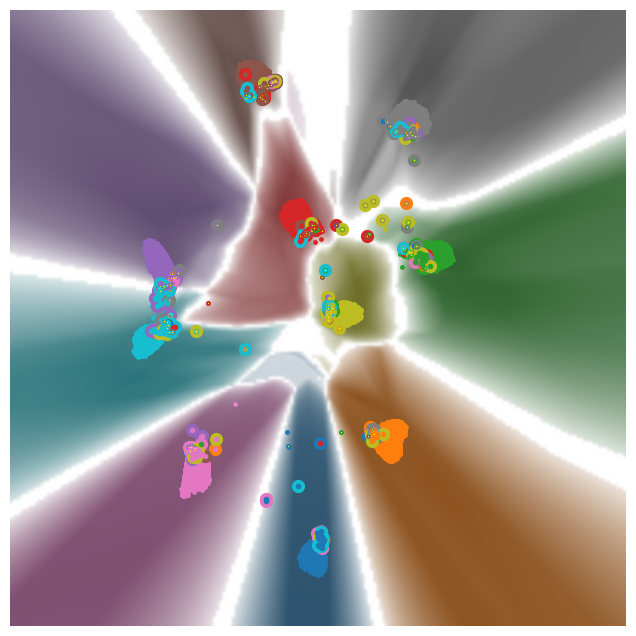

In [30]:
epoch = 8
from singleVis.visualizer_hlb_ import visualizer
border = data_provider.border_representation(epoch)
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi', device=DEVICE)  
vis = visualizer(data_provider, projector, 200, "tab10")
vis.savefig(epoch,path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, 'dvi_grid')))
# vis.get_background(15,200)
